In [1]:
import fitsio
import numpy as np
import numpy.lib.recfunctions as rec
import os
from matplotlib import pyplot as plt
# import astropy.units as u
# from astropy.coordinates import SkyCoord
# import scipy.optimize as opt
import scipy.odr as odr
from scipy.stats import pearsonr

#for 3D plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, cm
import subprocess

Need to read in data files.
- Spoo et al. Sample for open clusters
- Katelynn's globular clusters
- APOKASC DR16 Sample

In [2]:
def linear(x,m,b):
    return (m*x)+b

In [3]:
# reading in files
# apo_apok_rc_oc = fitsio.read('APOKASC_and_APOGEE_DR16plusdata_withRC_and_OCCAMlabels.fits')
apo_apok_rc_oc = fitsio.read('APOKASC_and_APOGEE_DR17data_withRC_and_OCCAMlabels.fits')

print(len(apo_apok_rc_oc))
# print(apo_apok_rc_oc.dtype)
print(np.unique(apo_apok_rc_oc["CLUSTER_LABEL"]))
# print(apo_apok_rc_oc['C_FE'])

14932
['NGC 6791' 'NGC 6811' 'NGC 6819' 'NGC 6866' 'NON MEM']


In [4]:
# test = fitsio.read('APOKASC_v705_and_APOGEE_DR17data_OCCAMlabels.fits')
# test.dtype
# print(len(test), len(apo_apok_rc_oc))

In [5]:
print(np.max(apo_apok_rc_oc['FE_H']))
print(np.min(apo_apok_rc_oc['FE_H']))

0.49811
-2.4277


In [6]:
#selecting cuts: remove RC, SN>70, FDU Logg Cut (at least for metal rich stars)
# select only non cluster mems
# remove bad values from APOKACS
# FEH cut >= -0.82
rc_cluster_cut = (apo_apok_rc_oc['RC_LABEL']=="NOT RC") & (apo_apok_rc_oc['CLUSTER_LABEL']=="NON MEM") &\
(apo_apok_rc_oc['APOKACS2_AGE']>-100) & (apo_apok_rc_oc['LOGG']<3.2) & (apo_apok_rc_oc['SNREV']>70) &\
(apo_apok_rc_oc['FE_H'] >=-0.82) & (apo_apok_rc_oc['C_FE']!=-9999.99) & (apo_apok_rc_oc['N_FE']!=-9999.99)

clean_apok = apo_apok_rc_oc[rc_cluster_cut]
print(np.min(clean_apok['FE_H']))
print(np.max(clean_apok['FE_H']))
print(np.min(clean_apok['LOGG']))

-0.81684
0.45955
1.1748579


In [7]:
#From Spoo et al code: 
# (cn_fullNGC6819>=-0.624)(cut off for young clusters) & (cn_err_fullNGC6819<=0.1)
CN_abund = apo_apok_rc_oc['C_FE']-apo_apok_rc_oc['N_FE']
CN_err = np.sqrt(apo_apok_rc_oc['C_FE_ERR']**2+apo_apok_rc_oc['N_FE_ERR']**2)
# print(np.min(CN_err))
#THERE ARE FREAKING NANS IN THE DATA FILE!!!! >_<

In [8]:
ngc6791_cut = (apo_apok_rc_oc['RC_LABEL']=="NOT RC") & (apo_apok_rc_oc['CLUSTER_LABEL']=="NGC 6791") &\
(apo_apok_rc_oc['APOKACS2_AGE']>-100) & (apo_apok_rc_oc['LOGG']<3.3) & (apo_apok_rc_oc['SNREV']>70) &\
(apo_apok_rc_oc['RV_PROB']>=0.01) & (apo_apok_rc_oc['FEH_PROB']>=0.01) & (apo_apok_rc_oc['PM_PROB']>=0.01)

# tot_prob_cut

ngc6811_cut = (apo_apok_rc_oc['RC_LABEL']=="NOT RC") & (apo_apok_rc_oc['CLUSTER_LABEL']=="NGC 6811") &\
(apo_apok_rc_oc['APOKACS2_AGE']>-100) & (apo_apok_rc_oc['LOGG']<3.3) & (apo_apok_rc_oc['SNREV']>70) &\
(apo_apok_rc_oc['RV_PROB']>=0.01) & (apo_apok_rc_oc['FEH_PROB']>=0.01) & (apo_apok_rc_oc['PM_PROB']>=0.01)
# tot_prob_cut

ngc6819_cut = (apo_apok_rc_oc['RC_LABEL']=="NOT RC") & (apo_apok_rc_oc['CLUSTER_LABEL']=="NGC 6819") &\
(apo_apok_rc_oc['APOKACS2_AGE']>-100) & (apo_apok_rc_oc['LOGG']<3.3) & (apo_apok_rc_oc['SNREV']>70) &\
(apo_apok_rc_oc['RV_PROB']>=0.01) & (apo_apok_rc_oc['FEH_PROB']>=0.01) & (apo_apok_rc_oc['PM_PROB']>=0.01)
# tot_prob_cut

NGC6791 = apo_apok_rc_oc[ngc6791_cut]
NGC6811 = apo_apok_rc_oc[ngc6811_cut]
NGC6819 = apo_apok_rc_oc[ngc6819_cut]
print(len(NGC6791), len(NGC6811), len(NGC6819))

12 3 24


In [9]:
metal_rich = (clean_apok['FE_H']>-0.5) & (clean_apok['FE_H']<0.31) &(clean_apok['LOGG']>0)
metal_poor = clean_apok['FE_H']<-0.5
metal_poor_unmix = (clean_apok['FE_H']<-0.5) & (clean_apok['LOGG']>2.2) #extra-mixing,logg cut from Shetrone 2019
no_rc = clean_apok['LOGG']>0.002*(clean_apok['TEFF']-4800)+2.45
print(len(clean_apok[metal_rich]))
print(len(clean_apok[metal_poor_unmix]))
apok_mpoor = clean_apok[metal_poor_unmix & no_rc]
apok_mrich = clean_apok[metal_rich & no_rc]
useable_stars = np.hstack((apok_mrich,apok_mpoor))
print(len(apok_mpoor)+len(apok_mrich))
print(len(useable_stars))
# useable_stars.dtype

4162
152
3764
3764


In [10]:
m_cut = (2.2-2.9)/(3.67-3.71)
print(m_cut)
b_cut = 0 #-40
x_vals = np.linspace(np.log10(3600),np.log10(5200),10)
teff_vals = np.linspace(4000, 5200,100)
print(np.unique(clean_apok['RC_LABEL']))

17.49999999999998
['NOT RC']


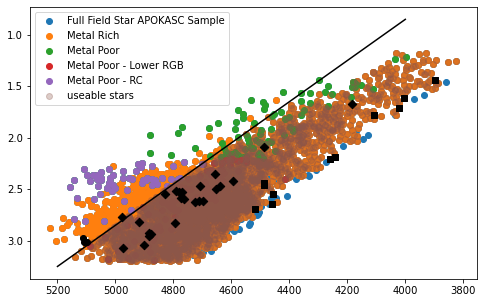

In [11]:
# plt.scatter(clean_apok['TEFF'], clean_apok['LOGG'])
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

ax.scatter(clean_apok['TEFF'], clean_apok['LOGG'], label="Full Field Star APOKASC Sample")
# ax.scatter(np.log10(clean_apok['TEFF'][metal_rich]), clean_apok['LOGG'][metal_rich],
#            label="Metal Rich")
ax.scatter(clean_apok['TEFF'][metal_rich], clean_apok['LOGG'][metal_rich], label="Metal Rich")
ax.scatter((clean_apok['TEFF'][metal_poor]), clean_apok['LOGG'][metal_poor],
           label="Metal Poor")
ax.scatter((clean_apok['TEFF'][metal_poor_unmix & no_rc]), clean_apok['LOGG'][metal_poor_unmix & no_rc],
           label="Metal Poor - Lower RGB")
ax.scatter((clean_apok['TEFF'][metal_poor_unmix & ~no_rc]),
           clean_apok['LOGG'][metal_poor_unmix & ~no_rc],
           label="Metal Poor - RC")
ax.scatter(useable_stars['TEFF'], useable_stars['LOGG'], label="useable stars", alpha=0.3)

ax.scatter(NGC6791['TEFF'], NGC6791['LOGG'], c='k', marker='s')
ax.scatter(NGC6811['TEFF'], NGC6811['LOGG'], c='k', marker='o')
ax.scatter(NGC6819['TEFF'], NGC6819['LOGG'], c='k', marker='D')

# ax.scatter((clean_apok['TEFF'][metal_rich | metal_poor_unmix & no_rc]), 
#            clean_apok['LOGG'][(metal_rich | metal_poor_unmix) & no_rc], label="usable stars")
# ax.scatter((clean_apok['TEFF'][metal_poor_unmix &(clean_apok['RC_LABEL']=="RC")]),
#            clean_apok['LOGG'][metal_poor_unmix &(clean_apok['RC_LABEL']=="RC")],
#            label="Metal Poor - RC")
# ax.plot(x_vals, linear(x_vals,m_cut,b_cut), color='k')
ax.plot(teff_vals, 0.002*(teff_vals-4800)+2.45, color='k')
# ax.plot(teff_vals, 0.001*(teff_vals-4800)+2.75, color='r')

ax.legend()
ax.invert_xaxis()
ax.invert_yaxis()
# ax.set_xlim(left=3.4, right=4)
# ax.set_ylim(top=4,bottom=0)

In [12]:
apok_rgb_cali = clean_apok[metal_poor_unmix & no_rc]
print(len(apok_rgb_cali))
print(len(clean_apok[metal_poor]))
print(f"{(len(apok_rgb_cali)/len(clean_apok[metal_poor]))*100:.2f}%")

96
236
40.68%


Rerun the calibration fits with ODR

Goodness of fit tests? How do I compare which fit is better than the other? Linear/Quadratic/etc.? (a function that asymptotes to some value (idk the age of the unvierse)?)

Actually including the GC calibration sample increases the linear correlation between [C/N] and Age. This supports a linear fit over nonlinear.

- Pearson Coeff (R) Spoo Sample + 47Tuc + M71: 0.84
- Pearson Coeff (R) Spoo Sample: 0.79

NOTE: Age of the universe is 13.8 Gyrs (Log(Age{yrs})=10.14) (NEED A PAPER TO CITE?)

In [13]:
#CHECK which way these value were calculated slope = CN/AGE -OR- AGE/CN!!
# Linear Fit Spoo sample + GCs OUTPUT:
# m = 2.4503898615795023; b = 10.215481284250897
# m_err = 0.2058772340764095; b_err = 0.08416610872255481

# with Kaleo's clusters - m = 2.41206528 --> b = 10.20375749 
# m_err = .19799395 --> b_err = .08147377 
lin_coeff = [2.45, 10.22] 
lin_coeff_err = [0.21, 0.08]

def CN_age_linfit(cn_val, coeffs):
    age = (cn_vals*coeffs[0])+coeffs[1]
    return age

def convert_Gyrs2logAge(age_gyr):
    return np.log10(age_gyr*1e9)

#DONT WANT TO USE QUAD. FIT BASED ON JAMIE'S INPUT!!
# Quadratic Fit Spoo sample + GCs OUTPUT:
# a = -1.695641270728612; b = 1.3780207347931281; c = 10.08188571700156
# a_err = 0.9089750905517162; b_err = 0.5564140105716058; c_err = 0.09080074604613694
quad_coeff = [-1.70, 1.38, 10.08]

def CN_age_quadfit(cn_val, coeffs):
    age = ((cn_val**2)*coeffs[0]) + (cn_val*coeffs[1]) + (coeffs[2])
    return age

In [14]:
m = lin_coeff[0]
m_err = lin_coeff_err[0]
b = lin_coeff[1]
b_err = lin_coeff_err[1]

cn_abund = useable_stars['C_FE']-useable_stars['N_FE']
cn_err = np.sqrt(useable_stars['C_FE_ERR']**2+useable_stars['N_FE_ERR']**2)
cn_cut = (cn_abund>=-0.624) & (cn_err<=0.1)

cn_6811 = NGC6811['C_FE']-NGC6811['N_FE']
cn_6819 = NGC6819['C_FE']-NGC6819['N_FE']
cn_6791 = NGC6791['C_FE']-NGC6791['N_FE']

cn_err_6811 = np.sqrt(NGC6811['C_FE_ERR']**2+NGC6811['N_FE_ERR']**2)
cn_err_6819 = np.sqrt(NGC6819['C_FE_ERR']**2+NGC6819['N_FE_ERR']**2)
cn_err_6791 = np.sqrt(NGC6791['C_FE_ERR']**2+NGC6791['N_FE_ERR']**2)

cn_cut_6811 = (cn_6811>=-0.624) & (cn_err_6811<=0.1)
cn_cut_6819 = (cn_6819>=-0.624) & (cn_err_6819<=0.1)
cn_cut_6791 = (cn_6791>=-0.624) & (cn_err_6791<=0.1)

apok_logage = np.log10(useable_stars['APOKACS2_AGE'][cn_cut]*1e9)
apokPerr_logage = (np.log10((useable_stars['APOKACS2_AGE'][cn_cut]+useable_stars['APOKASC2_AGE_PERR'][cn_cut])*(1e9))-apok_logage)
apokMerr_logage = (np.log10((useable_stars['APOKACS2_AGE'][cn_cut]-useable_stars['APOKASC2_AGE_MERR'][cn_cut])*(1e9))-apok_logage)
print(np.max(apokPerr_logage),  np.max(np.abs(apokMerr_logage))) #using plus value
print(np.median(apokPerr_logage), np.median(apokMerr_logage))

cali_age = (cn_abund[cn_cut]*lin_coeff[0])+(lin_coeff[1])
# print(len(NGC6791))
# print(cn_cut_6791)
del_a = (m * cn_abund)*np.sqrt((m_err/m)**2 + (cn_err/cn_abund)**2)
cali_age_err = (np.sqrt((del_a**2)+(b_err**2)))[cn_cut]

delta_age = np.sqrt(apokPerr_logage**2+cali_age_err**2)

apok_logage_NGC6811 = np.log10((NGC6811['APOKACS2_AGE'][cn_cut_6811])*1e9)
apok_logage_NGC6791 = np.log10((NGC6791['APOKACS2_AGE'][cn_cut_6791])*1e9)
apok_logage_NGC6819 = np.log10((NGC6819['APOKACS2_AGE'][cn_cut_6819])*1e9)

cali_age_NGC6811 = ((cn_6811[cn_cut_6811])*lin_coeff[0])+(lin_coeff[1])
# del_a_6811 = (m * cn_6811)*np.sqrt((m_err/m)**2 + (cn_err_6811/cn_6811)**2)
# cali_age_err_6811 = (np.sqrt((del_a**2)+(b_err**2)))[cn_cut]

cali_age_NGC6791 = ((cn_6791[cn_cut_6791])*lin_coeff[0])+(lin_coeff[1])
# del_a = (m * cn_abund)*np.sqrt((m_err/m)**2 + (cn_err/cn_abund)**2)
# cali_age_err = (np.sqrt((del_a**2)+(b_err**2)))[cn_cut]

cali_age_NGC6819 = ((cn_6819[cn_cut_6819])*lin_coeff[0])+(lin_coeff[1])
# del_a = (m * cn_abund)*np.sqrt((m_err/m)**2 + (cn_err/cn_abund)**2)
# cali_age_err = (np.sqrt((del_a**2)+(b_err**2)))[cn_cut]

# print(np.min(cali_age_NGC6819))
# n6819_old = np.where(cali_age_NGC6819==10.583784)
# print(NGC6819['LOGG'][n6819_old],NGC6819['TEFF'][n6819_old],NGC6819['SNREV'][n6819_old],
#       NGC6819['FE_H'][n6819_old],(NGC6819['C_FE']-NGC6819['N_FE'])[n6819_old])
# print(np.max(cali_age_NGC6819))
# n6819_yng = np.where(cali_age_NGC6819==8.496719)
# print(NGC6819['LOGG'][n6819_yng],NGC6819['TEFF'][n6819_yng],NGC6819['SNREV'][n6819_yng],
#       NGC6819['FE_H'][n6819_yng],(NGC6819['C_FE']-NGC6819['N_FE'])[n6819_yng])
# print(NGC6819['LOGG'])

# print(np.max(apok_logage))
# print(np.max(cali_age))
# print(np.log10(13.8e9))
# print(len(cali_age[cali_age>np.log10(13.8e9)]))
# print(len(cali_age[cali_age<np.log10(13.8e9)]))
# print(726/2895)

high_cn = np.where((cn_abund[cn_cut]>-0.1) & (cn_abund[cn_cut]<0.1))

too_old_idx = np.where(cali_age>np.log10(13.8e9)) #10.25 #np.log10(13.8e9)
too_old_aidx = np.where(apok_logage>np.log10(13.8e9))
too_old = useable_stars[cn_cut][too_old_idx]
too_old_apok = useable_stars[cn_cut][too_old_aidx]
print(f"{len(too_old)}/{len(cali_age)}")
print(len(too_old)/len(cali_age))
print(f"{len(too_old_apok)}/{len(apok_logage)}")
print(len(too_old_apok)/len(apok_logage))
# print("[ALPHA/Fe]:",np.round(too_old['ALPHA_M']+too_old['M_H']-too_old['FE_H'], decimals=2))
# print("[Fe/H]:", np.round(too_old['FE_H'], decimals=2))
# print("[Mg/Fe]:", np.round(too_old['MG_FE'], decimals=2))
# print("[C/N]:",np.round(too_old['C_FE']-too_old['N_FE'], decimals=2))
# print(np.min(too_old['C_FE']-too_old['N_FE']), np.max(too_old['C_FE']-too_old['N_FE']))
# print(cali_age[too_old_idx])

# print(useable_stars[high_cn])
# print(cali_age[high_cn])
# print(np.min(useable_stars[high_cn]['C_FE']-useable_stars[high_cn]['N_FE']),
#       np.max(useable_stars[high_cn]['C_FE']-useable_stars[high_cn]['N_FE']))
# print(too_old['C_FE'])
# print(too_old['N_FE'])

# print(apok_logage)
# print(cali_age)

# print(np.min(apok_logage))
# print(np.min(cali_age))
# print(np.max(apok_logage))
# print(np.max(cali_age))
# badstar = np.where(cali_age==24510.568)
# print(badstar)
# print(useable_stars['C_FE'][badstar], useable_stars['N_FE'][badstar])
# cali_age_err = np.sqrt(useable_stars['C_FE_ERR']**2+useable_stars['C'])

0.46799946 0.40600014
0.06700039 -0.06499958
354/3722
0.09511015583019881
109/3722
0.029285330467490597


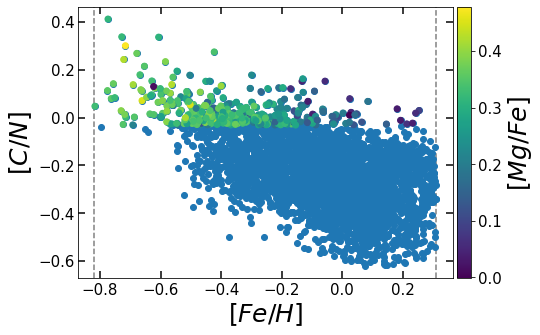

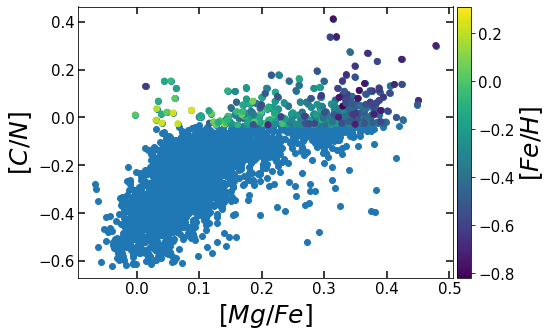

In [15]:
# alpha_poor_cut_us = ()
# alpha_rich_cut_us = 

# alpha_poor_cut_to = 
# alpha_rich_cut_to = 

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

# ax.scatter(useable_stars['MG_FE'][cn_cut], (useable_stars['C_FE']-useable_stars['N_FE'])[cn_cut],
#            c=cali_age, vmax=11, vmin=8.5)
# ax.scatter(too_old['MG_FE'], too_old['C_FE']-too_old['N_FE'],
#            c=cali_age[too_old_idx], vmax=11, vmin=8.5, marker='s')
ax.scatter(useable_stars['FE_H'][cn_cut], (useable_stars['C_FE']-useable_stars['N_FE'])[cn_cut])
image = ax.scatter(too_old['FE_H'], too_old['C_FE']-too_old['N_FE'],c=too_old['MG_FE'])
bar = fig.colorbar(image,orientation="vertical",pad=0.01)
bar.ax.tick_params(labelsize=15)
bar.set_label('$[Mg/Fe]$',size=25)
ax.axvline(-0.82, c='grey', linestyle="--", zorder=0)
ax.axvline(0.31, c='grey', linestyle="--", zorder=0)

ax.set_xlabel('$[Fe/H]$', size=25)
ax.set_ylabel('$[C/N]$', size=25)
lineweight = 1.5   # thickness of tick marks
numsize = 15       # size of numbers on axs
ax.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

# ax.scatter(useable_stars['MG_FE'][cn_cut], (useable_stars['C_FE']-useable_stars['N_FE'])[cn_cut],
#            c=cali_age, vmax=11, vmin=8.5)
# ax.scatter(too_old['MG_FE'], too_old['C_FE']-too_old['N_FE'],
#            c=cali_age[too_old_idx], vmax=11, vmin=8.5, marker='s')
ax.scatter(useable_stars['MG_FE'][cn_cut], (useable_stars['C_FE']-useable_stars['N_FE'])[cn_cut])
image = ax.scatter(too_old['MG_FE'], too_old['C_FE']-too_old['N_FE'],
                   vmin=-0.82, vmax=0.31, c=too_old['FE_H'])
bar = fig.colorbar(image,orientation="vertical",pad=0.01)
bar.ax.tick_params(labelsize=15)
bar.set_label('$[Fe/H]$',size=25)

# ax.axvline(-0.82, c='grey', linestyle="--", zorder=0)
# ax.axvline(0.31, c='grey', linestyle="--", zorder=0)

ax.set_xlabel('$[Mg/Fe]$', size=25)
ax.set_ylabel('$[C/N]$', size=25)
lineweight = 1.5   # thickness of tick marks
numsize = 15       # size of numbers on axs
ax.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)


In [16]:
odrData = odr.RealData(apok_logage, cali_age, sx=apokPerr_logage, sy=cali_age_err)
good_odr = odr.ODR(odrData, odr.unilinear, beta0=[1,0])
output = good_odr.run()
fit_vals = output.beta
fit_vals_err = output.sd_beta
print(fit_vals)
print(fit_vals_err)

[ 1.09342446 -0.9187164 ]
[0.01411596 0.13705778]


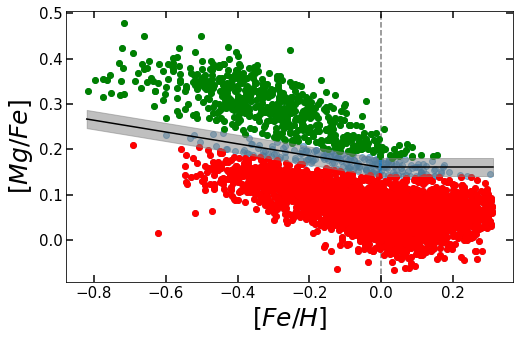

In [17]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

feh_vals = np.linspace(-0.82,0.31,100)
low_feh = feh_vals<=0.0
high_feh = feh_vals>=0.0
rel_stars = useable_stars[cn_cut]

high_alpha_hfeh = (rel_stars['MG_FE']>0.16+0.02) & (rel_stars['FE_H']>0.0)
high_alpha_lfeh = (rel_stars['MG_FE']>(0.16+0.02)-0.13*rel_stars['FE_H']) & (rel_stars['FE_H']<0.0)
high_alpha = high_alpha_hfeh | high_alpha_lfeh
low_alpha_hfeh = (rel_stars['MG_FE']<0.16-0.02) & (rel_stars['FE_H']>0.0)
low_alpha_lfeh = (rel_stars['MG_FE']<(0.16-0.02)-0.13*rel_stars['FE_H']) & (rel_stars['FE_H']<0.0)
low_alpha = low_alpha_hfeh | low_alpha_lfeh

ax.scatter(rel_stars['FE_H'], rel_stars['MG_FE'], alpha=0.5)
# ax.scatter(rel_stars['FE_H'][high_alpha_hfeh], rel_stars['MG_FE'][high_alpha_hfeh], c="g")
# ax.scatter(rel_stars['FE_H'][high_alpha_lfeh], rel_stars['MG_FE'][high_alpha_lfeh], c="tab:green")
ax.scatter(rel_stars['FE_H'][high_alpha], rel_stars['MG_FE'][high_alpha], c="g")
# ax.scatter(rel_stars['FE_H'][low_alpha_hfeh], rel_stars['MG_FE'][low_alpha_hfeh], c='r' )
# ax.scatter(rel_stars['FE_H'][low_alpha_lfeh], rel_stars['MG_FE'][low_alpha_lfeh], c='tab:red' )
ax.scatter(rel_stars['FE_H'][low_alpha], rel_stars['MG_FE'][low_alpha], c="r")

ax.plot(feh_vals[low_feh], (0.16-(0.13*feh_vals))[low_feh], c='k', ls='-')
ax.fill_between(feh_vals[low_feh], (0.16-(0.13*feh_vals))[low_feh]+0.02, (0.16-(0.13*feh_vals))[low_feh]-0.02,
                color='grey', alpha=0.5)
ax.plot(feh_vals[high_feh], (feh_vals[high_feh]*0)+0.16, c='k', ls='-')
ax.fill_between(feh_vals[high_feh], (feh_vals[high_feh]*0)+0.16+0.02, (feh_vals[high_feh]*0)+0.16-0.02,
               color='grey', alpha=0.5)
ax.axvline(0.0, c='grey', linestyle="--", zorder=0)

# ax.legend()
# ax.invert_xaxis()
# ax.invert_yaxis()
# ax.set_xlim(left=3.4, right=4)
# ax.set_ylim(top=4,bottom=0)
ax.set_xlabel('$[Fe/H]$', size=25)
ax.set_ylabel('$[Mg/Fe]$', size=25)
lineweight = 1.5   # thickness of tick marks
numsize = 15       # size of numbers on axs
ax.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)


In [18]:
high_alpha_hfeh_to = (too_old['MG_FE']>0.16+0.02) & (too_old['FE_H']>0.0)
high_alpha_lfeh_to = (too_old['MG_FE']>(0.16+0.02)-0.13*too_old['FE_H']) & (too_old['FE_H']<0.0)
high_alpha_to = high_alpha_hfeh_to | high_alpha_lfeh_to
low_alpha_hfeh_to = (too_old['MG_FE']<0.16-0.02) & (too_old['FE_H']>0.0)
low_alpha_lfeh_to = (too_old['MG_FE']<(0.16-0.02)-0.13*too_old['FE_H']) & (too_old['FE_H']<0.0)
low_alpha_to = low_alpha_hfeh_to | low_alpha_lfeh_to

print(np.median(too_old['FE_H']))
print(np.mean(too_old['FE_H']))
print(np.std(too_old['FE_H']))
print(len(too_old))

-0.363465
-0.34861836
0.1978015
354


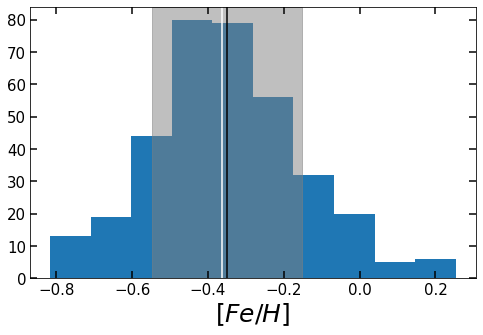

In [19]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

ax.hist(too_old['FE_H'])
# ax.hist
ax.axvline(np.mean(too_old['FE_H']), c='k')
ax.axvline(np.median(too_old['FE_H']), c='w')
ax.axvspan(np.mean(too_old['FE_H'])-np.std(too_old['FE_H']), np.mean(too_old['FE_H'])+np.std(too_old['FE_H']),
           alpha=0.5, color='grey')
ax.set_xlabel("$[Fe/H]$", size=25)
lineweight = 1.5   # thickness of tick marks
numsize = 15       # size of numbers on axs
ax.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)


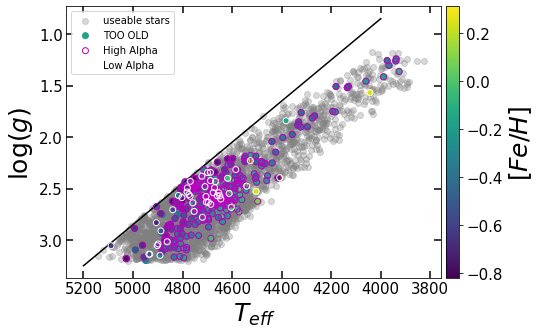

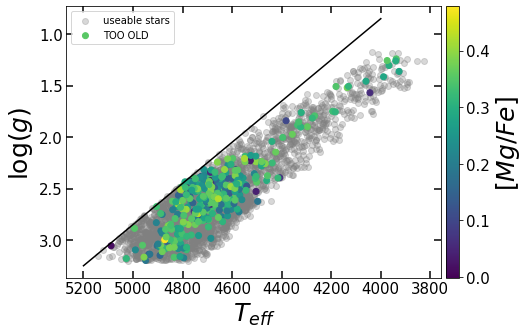

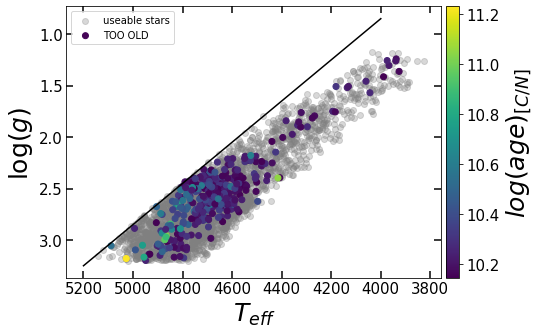

In [20]:
# plt.scatter(clean_apok['TEFF'], clean_apok['LOGG'])
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

# ax.scatter(clean_apok['TEFF'], clean_apok['LOGG'], label="Full Field Star APOKASC Sample")

ax.scatter(useable_stars[cn_cut]['TEFF'], useable_stars[cn_cut]['LOGG'],
           c='grey', label="useable stars", alpha=0.3)
image = ax.scatter(too_old['TEFF'], too_old['LOGG'],c=too_old['FE_H'],
                   vmin=-0.82, vmax=0.31, label="TOO OLD")
ax.scatter(too_old['TEFF'][high_alpha_to], too_old['LOGG'][high_alpha_to], label='High Alpha',
           c="none", edgecolors='m', zorder=5)
ax.scatter(too_old['TEFF'][low_alpha_to], too_old['LOGG'][low_alpha_to], label='Low Alpha',
           c="none", edgecolors='w', zorder=5)


bar = fig.colorbar(image,orientation="vertical",pad=0.01)
bar.ax.tick_params(labelsize=15)
bar.set_label('$[Fe/H]$',size=25)

# ax.scatter(NGC6791['TEFF'], NGC6791['LOGG'], c='b', marker='s', label='NGC6791')
# ax.scatter(NGC6811['TEFF'], NGC6811['LOGG'], c='m', marker='o', label='NGC6811')
# ax.scatter(NGC6819['TEFF'], NGC6819['LOGG'], c='k', marker='D', label='NGC6819')
# ax.scatter(NGC6819['TEFF'][n6819_old], NGC6819['LOGG'][n6819_old], c='r', marker='X')
# ax.scatter(NGC6819['TEFF'][n6819_yng], NGC6819['LOGG'][n6819_yng], c='r', marker='X')

ax.plot(teff_vals, 0.002*(teff_vals-4800)+2.45, color='k')
# ax.plot(teff_vals, 0.001*(teff_vals-4800)+2.75, color='r')

# ax.axhline(2.54, c='grey', ls='--')
# ax.axhline(2.46, c='grey', ls='--')
# ax.axhline(3.1, c='grey', ls='--')

ax.legend()
ax.invert_xaxis()
ax.invert_yaxis()
# ax.set_xlim(left=3.4, right=4)
# ax.set_ylim(top=4,bottom=0)
ax.set_xlabel('$T_{eff}$', size=25)
ax.set_ylabel('$\log(g)$', size=25)
lineweight = 1.5   # thickness of tick marks
numsize = 15       # size of numbers on axs
ax.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)


# plt.scatter(clean_apok['TEFF'], clean_apok['LOGG'])
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

# ax.scatter(clean_apok['TEFF'], clean_apok['LOGG'], label="Full Field Star APOKASC Sample")

ax.scatter(useable_stars[cn_cut]['TEFF'], useable_stars[cn_cut]['LOGG'], c='grey', label="useable stars", alpha=0.3)

image = ax.scatter(too_old['TEFF'], too_old['LOGG'],c=too_old['MG_FE'], label="TOO OLD")
bar = fig.colorbar(image,orientation="vertical",pad=0.01)
bar.ax.tick_params(labelsize=15)
bar.set_label('$[Mg/Fe]$',size=25)

# ax.scatter(NGC6791['TEFF'], NGC6791['LOGG'], c='b', marker='s', label='NGC6791')
# ax.scatter(NGC6811['TEFF'], NGC6811['LOGG'], c='m', marker='o', label='NGC6811')
# ax.scatter(NGC6819['TEFF'], NGC6819['LOGG'], c='k', marker='D', label='NGC6819')
# ax.scatter(NGC6819['TEFF'][n6819_old], NGC6819['LOGG'][n6819_old], c='r', marker='X')
# ax.scatter(NGC6819['TEFF'][n6819_yng], NGC6819['LOGG'][n6819_yng], c='r', marker='X')

ax.plot(teff_vals, 0.002*(teff_vals-4800)+2.45, color='k')
# ax.plot(teff_vals, 0.001*(teff_vals-4800)+2.75, color='r')

ax.legend()
ax.invert_xaxis()
ax.invert_yaxis()
# ax.set_xlim(left=3.4, right=4)
# ax.set_ylim(top=4,bottom=0)
ax.set_xlabel('$T_{eff}$', size=25)
ax.set_ylabel('$\log(g)$', size=25)
lineweight = 1.5   # thickness of tick marks
numsize = 15       # size of numbers on axs
ax.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)


# plt.scatter(clean_apok['TEFF'], clean_apok['LOGG'])
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

# ax.scatter(clean_apok['TEFF'], clean_apok['LOGG'], label="Full Field Star APOKASC Sample")

ax.scatter(useable_stars[cn_cut]['TEFF'], useable_stars[cn_cut]['LOGG'], c='grey', label="useable stars", alpha=0.3)

image = ax.scatter(too_old['TEFF'], too_old['LOGG'],c=cali_age[too_old_idx], label="TOO OLD")
bar = fig.colorbar(image,orientation="vertical",pad=0.01)
bar.ax.tick_params(labelsize=15)
bar.set_label('$log(age)_{[C/N]}$',size=25)

# ax.scatter(NGC6791['TEFF'], NGC6791['LOGG'], c='b', marker='s', label='NGC6791')
# ax.scatter(NGC6811['TEFF'], NGC6811['LOGG'], c='m', marker='o', label='NGC6811')
# ax.scatter(NGC6819['TEFF'], NGC6819['LOGG'], c='k', marker='D', label='NGC6819')
# ax.scatter(NGC6819['TEFF'][n6819_old], NGC6819['LOGG'][n6819_old], c='r', marker='X')
# ax.scatter(NGC6819['TEFF'][n6819_yng], NGC6819['LOGG'][n6819_yng], c='r', marker='X')

ax.plot(teff_vals, 0.002*(teff_vals-4800)+2.45, color='k')
# ax.plot(teff_vals, 0.001*(teff_vals-4800)+2.75, color='r')

ax.legend()
ax.invert_xaxis()
ax.invert_yaxis()
# ax.set_xlim(left=3.4, right=4)
# ax.set_ylim(top=4,bottom=0)
ax.set_xlabel('$T_{eff}$', size=25)
ax.set_ylabel('$\log(g)$', size=25)
lineweight = 1.5   # thickness of tick marks
numsize = 15       # size of numbers on axs
ax.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)


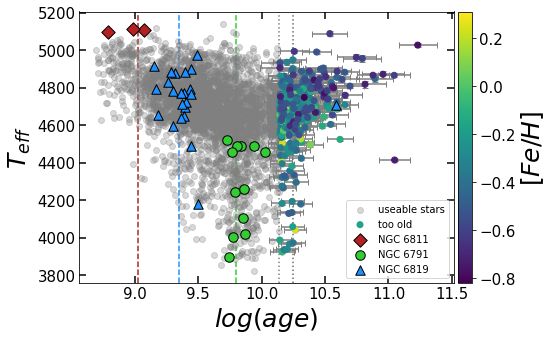

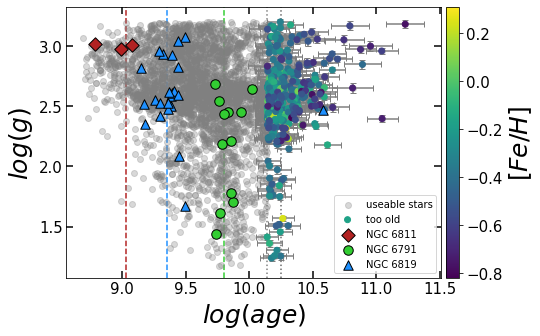

In [21]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

ax.scatter(cali_age, useable_stars[cn_cut]['TEFF'], c='grey', label="useable stars", alpha=0.3)
image = ax.scatter(cali_age[too_old_idx], too_old['TEFF'], c=too_old['FE_H'], 
                   vmin=-0.82, vmax=0.31, label="too old")
bar = fig.colorbar(image,orientation="vertical",pad=0.01)
bar.ax.tick_params(labelsize=15)
bar.set_label('$[Fe/H]$',size=25)
ax.errorbar(cali_age[too_old_idx], too_old['TEFF'], 
            yerr=too_old['TEFF_ERR'], xerr=cali_age_err[too_old_idx],
            c='tab:gray',fmt='.', markersize=.5, capsize=3, zorder=0)

ax.scatter(cali_age_NGC6811, NGC6811[cn_cut_6811]['TEFF'], edgecolors='k',
           zorder=5, alpha=1, label="NGC 6811", c="firebrick", s=90, marker="D")
ax.scatter(cali_age_NGC6791, NGC6791[cn_cut_6791]['TEFF'], edgecolors='k',
           zorder=5, alpha=1, c='limegreen', label="NGC 6791", s=90, marker="o")
ax.scatter(cali_age_NGC6819, NGC6819[cn_cut_6819]['TEFF'], edgecolors='k',
           zorder=5, alpha=1, c='dodgerblue', label="NGC 6819",s=90, marker="^")

ax.axvline(np.log10(13.8e9), c='grey', linestyle=":", zorder=0)
ax.axvline(10.25, c='dimgrey', linestyle=":", zorder=0)
ax.axvline(9.03, c="firebrick", zorder=0, linestyle="--")
ax.axvline(9.8, c="limegreen", zorder=0, linestyle="--")
ax.axvline(9.35, c="dodgerblue", zorder=0, linestyle="--")

ax.legend()
# ax.invert_xaxis()
# ax.invert_yaxis()
# ax.set_xlim(left=3.4, right=4)
# ax.set_ylim(top=4,bottom=0)
ax.set_xlabel('$log(age)$', size=25)
ax.set_ylabel('$T_{eff}$', size=25)
lineweight = 1.5   # thickness of tick marks
numsize = 15       # size of numbers on axs
ax.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

ax.scatter(cali_age, useable_stars[cn_cut]['LOGG'], c='grey', label="useable stars", alpha=0.3)
image = ax.scatter(cali_age[too_old_idx], too_old['LOGG'], c=too_old['FE_H'], 
                   vmin=-0.82, vmax=0.31, label="too old")
bar = fig.colorbar(image,orientation="vertical",pad=0.01)
bar.ax.tick_params(labelsize=15)
bar.set_label('$[Fe/H]$',size=25)
ax.errorbar(cali_age[too_old_idx], too_old['LOGG'], 
            yerr=too_old['LOGG_ERR'], xerr=cali_age_err[too_old_idx],
            c='tab:gray',fmt='.', markersize=.5, capsize=3, zorder=0)

ax.scatter(cali_age_NGC6811, NGC6811[cn_cut_6811]['LOGG'], edgecolors='k',
           zorder=5, alpha=1, label="NGC 6811", c="firebrick", s=90, marker="D")
ax.scatter(cali_age_NGC6791, NGC6791[cn_cut_6791]['LOGG'], edgecolors='k',
           zorder=5, alpha=1, c='limegreen', label="NGC 6791", s=90, marker="o")
ax.scatter(cali_age_NGC6819, NGC6819[cn_cut_6819]['LOGG'], edgecolors='k',
           zorder=5, alpha=1, c='dodgerblue', label="NGC 6819",s=90, marker="^")

ax.axvline(np.log10(13.8e9), c='grey', linestyle=":", zorder=0) # about 10.14 for log(Age) 
ax.axvline(10.25, c='dimgrey', linestyle=":", zorder=0) #where APOKASC oldest ages were
ax.axvline(9.03, c="firebrick", zorder=0, linestyle="--") #CG age for NGC6811
ax.axvline(9.8, c="limegreen", zorder=0, linestyle="--") #CG age for NGC6791
ax.axvline(9.35, c="dodgerblue", zorder=0, linestyle="--") #CG age for NGC6819

ax.legend()
# ax.invert_xaxis()
# ax.invert_yaxis()
# ax.set_xlim(left=3.4, right=4)
# ax.set_ylim(top=4,bottom=0)
ax.set_xlabel('$log(age)$', size=25)
ax.set_ylabel('$log(g)$', size=25)
lineweight = 1.5   # thickness of tick marks
numsize = 15       # size of numbers on axs
ax.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)


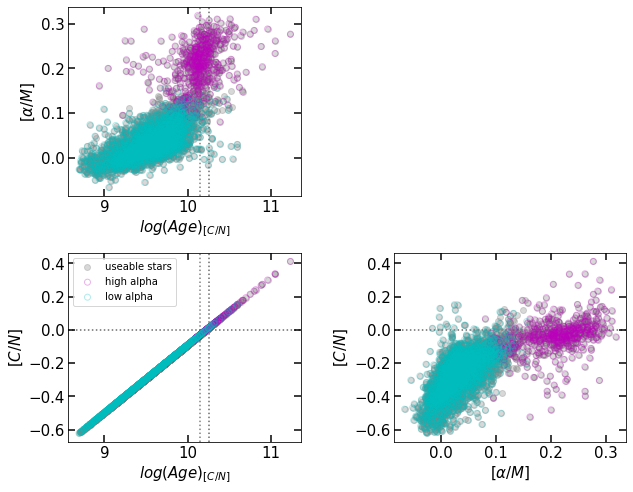

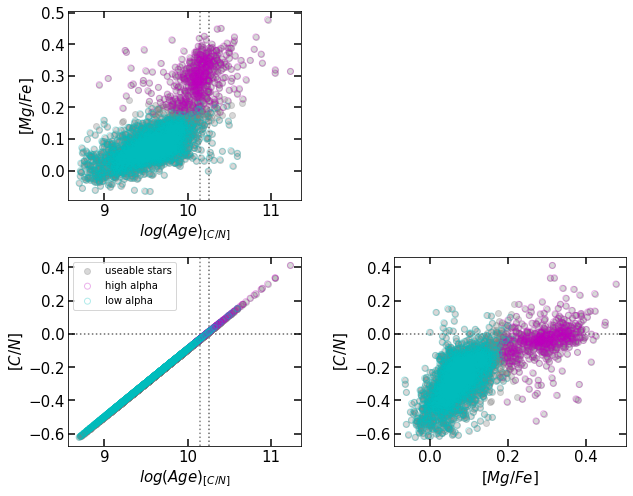

In [38]:
lineweight = 1.5   # thickness of tick marks
numsize = 15       # size of numbers on axs
fontsize = 15.     # size of axis labels

fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.3, wspace=0.4)
ax1 = fig.add_subplot(223)
ax2 = fig.add_subplot(221)
ax3 = fig.add_subplot(224)

ax1.scatter(cali_age, (rel_stars['C_FE']-rel_stars['N_FE']),
            c='grey', label="useable stars", alpha=0.3)
ax1.scatter(cali_age[high_alpha], (rel_stars['C_FE']-rel_stars['N_FE'])[high_alpha],
           c="none", edgecolors='m', label="high alpha", alpha=0.3)
ax1.scatter(cali_age[low_alpha], (rel_stars['C_FE']-rel_stars['N_FE'])[low_alpha],
           c="none", edgecolors='c', label="low alpha", alpha=0.3)
ax1.legend()
ax1.axvline(np.log10(13.8e9), c='grey', linestyle=":", zorder=0) # about 10.14 for log(Age) 
ax1.axvline(10.25, c='dimgrey', linestyle=":", zorder=0) #where APOKASC oldest ages were
ax1.axhline(0.0, c='dimgrey', linestyle=":", zorder=0)
ax1.set_ylabel('$[C/N]$', size=fontsize)
ax1.set_xlabel('$log(Age)_{[C/N]}$', size=fontsize)
ax1.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax1.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)



ax2.scatter(cali_age, rel_stars['ALPHA_M'], 
            c='grey', label="useable stars", alpha=0.3)
ax2.scatter(cali_age[high_alpha], rel_stars['ALPHA_M'][high_alpha], 
            c="none", edgecolors='m', label="high alpha", alpha=0.3)
ax2.scatter(cali_age[low_alpha], rel_stars['ALPHA_M'][low_alpha], 
            c="none", edgecolors='c', label="low alpha", alpha=0.3)
ax2.axvline(np.log10(13.8e9), c='grey', linestyle=":", zorder=0) # about 10.14 for log(Age) 
ax2.axvline(10.25, c='dimgrey', linestyle=":", zorder=0) #where APOKASC oldest ages were
ax2.set_ylabel(r'$[\alpha /M]$', size=fontsize)
ax2.set_xlabel('$log(Age)_{[C/N]}$', size=fontsize)
ax2.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax2.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)



ax3.scatter(rel_stars['ALPHA_M'], (rel_stars['C_FE']-rel_stars['N_FE']),
            c='grey', label="useable stars", alpha=0.3)
ax3.scatter(rel_stars['ALPHA_M'][high_alpha], (rel_stars['C_FE']-rel_stars['N_FE'])[high_alpha],
            c="none", edgecolors='m', label="high alpha", alpha=0.3)
ax3.scatter(rel_stars['ALPHA_M'][low_alpha], (rel_stars['C_FE']-rel_stars['N_FE'])[low_alpha],
            c="none", edgecolors='c', label="low alpha", alpha=0.3)
ax3.axhline(0.0, c='dimgrey', linestyle=":", zorder=0)
ax3.set_xlabel(r'$[\alpha/M]$', size=fontsize)
ax3.set_ylabel('$[C/N]$', size=fontsize)
ax3.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax3.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(cali_age, (rel_stars['C_FE']-rel_stars['N_FE']), rel_stars['ALPHA_M'],
#            c='grey', label="useable stars", alpha=0.3)
# ax.scatter(cali_age[high_alpha], (rel_stars['C_FE']-rel_stars['N_FE'])[high_alpha], rel_stars['ALPHA_M'][high_alpha],
#            c="none", edgecolors='m', label="high alpha", alpha=0.3)
# ax.scatter(cali_age[low_alpha], (rel_stars['C_FE']-rel_stars['N_FE'])[low_alpha], rel_stars['ALPHA_M'][low_alpha],
#            c="none", edgecolors='c', label="low alpha", alpha=0.3)

fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.3, wspace=0.4)
ax1 = fig.add_subplot(223)
ax2 = fig.add_subplot(221)
ax3 = fig.add_subplot(224)

ax1.scatter(cali_age, (rel_stars['C_FE']-rel_stars['N_FE']),
            c='grey', label="useable stars", alpha=0.3)
ax1.scatter(cali_age[high_alpha], (rel_stars['C_FE']-rel_stars['N_FE'])[high_alpha],
           c="none", edgecolors='m', label="high alpha", alpha=0.3)
ax1.scatter(cali_age[low_alpha], (rel_stars['C_FE']-rel_stars['N_FE'])[low_alpha],
           c="none", edgecolors='c', label="low alpha", alpha=0.3)
ax1.legend()
ax1.axvline(np.log10(13.8e9), c='grey', linestyle=":", zorder=0) # about 10.14 for log(Age) 
ax1.axvline(10.25, c='dimgrey', linestyle=":", zorder=0) #where APOKASC oldest ages were
ax1.axhline(0.0, c='dimgrey', linestyle=":", zorder=0)
ax1.set_ylabel('$[C/N]$', size=fontsize)
ax1.set_xlabel('$log(Age)_{[C/N]}$', size=fontsize)
ax1.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax1.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)



ax2.scatter(cali_age, rel_stars['MG_FE'], 
            c='grey', label="useable stars", alpha=0.3)
ax2.scatter(cali_age[high_alpha], rel_stars['MG_FE'][high_alpha], 
            c="none", edgecolors='m', label="high alpha", alpha=0.3)
ax2.scatter(cali_age[low_alpha], rel_stars['MG_FE'][low_alpha], 
            c="none", edgecolors='c', label="low alpha", alpha=0.3)
ax2.axvline(np.log10(13.8e9), c='grey', linestyle=":", zorder=0) # about 10.14 for log(Age) 
ax2.axvline(10.25, c='dimgrey', linestyle=":", zorder=0) #where APOKASC oldest ages were
ax2.set_ylabel(r'$[Mg/Fe]$', size=fontsize)
ax2.set_xlabel('$log(Age)_{[C/N]}$', size=fontsize)
ax2.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax2.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)



ax3.scatter(rel_stars['MG_FE'], (rel_stars['C_FE']-rel_stars['N_FE']),
            c='grey', label="useable stars", alpha=0.3)
ax3.scatter(rel_stars['MG_FE'][high_alpha], (rel_stars['C_FE']-rel_stars['N_FE'])[high_alpha],
            c="none", edgecolors='m', label="high alpha", alpha=0.3)
ax3.scatter(rel_stars['MG_FE'][low_alpha], (rel_stars['C_FE']-rel_stars['N_FE'])[low_alpha],
            c="none", edgecolors='c', label="low alpha", alpha=0.3)
ax3.axhline(0.0, c='dimgrey', linestyle=":", zorder=0)
ax3.set_xlabel(r'$[Mg/Fe]$', size=fontsize)
ax3.set_ylabel('$[C/N]$', size=fontsize)
ax3.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax3.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)



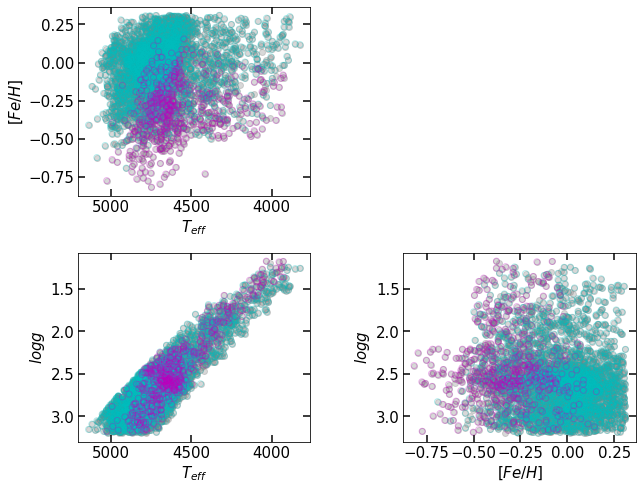

In [39]:
lineweight = 1.5   # thickness of tick marks
numsize = 15       # size of numbers on axs
fontsize = 15     # size of axis labels

fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.3, wspace=0.4)
ax1 = fig.add_subplot(223)
ax2 = fig.add_subplot(221)
ax3 = fig.add_subplot(224)

ax1.scatter(rel_stars['TEFF'], rel_stars['LOGG'],
            c='grey', label="useable stars", alpha=0.3)
ax1.scatter(rel_stars['TEFF'][high_alpha], rel_stars['LOGG'][high_alpha],
           c="none", edgecolors='m', label="high alpha", alpha=0.3, zorder=5)
ax1.scatter(rel_stars['TEFF'][low_alpha], rel_stars['LOGG'][low_alpha],
           c="none", edgecolors='c', label="low alpha", alpha=0.3)
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.set_ylabel('$logg$', size=fontsize)
ax1.set_xlabel('$T_{eff}$', size=fontsize)
ax1.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax1.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)



ax2.scatter(rel_stars['TEFF'], rel_stars['FE_H'], 
            c='grey', label="useable stars", alpha=0.3)
ax2.scatter(rel_stars['TEFF'][high_alpha], rel_stars['FE_H'][high_alpha], 
            c="none", edgecolors='m', label="high alpha", alpha=0.3, zorder=5)
ax2.scatter(rel_stars['TEFF'][low_alpha], rel_stars['FE_H'][low_alpha], 
            c="none", edgecolors='c', label="low alpha", alpha=0.3)
ax2.invert_xaxis()
# ax2.invert_yaxis()
ax2.set_ylabel(r'$[Fe/H]$', size=fontsize)
ax2.set_xlabel('$T_{eff}$', size=fontsize)
ax2.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax2.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)



ax3.scatter(rel_stars['FE_H'], rel_stars['LOGG'],
            c='grey', label="useable stars", alpha=0.3)
ax3.scatter(rel_stars['FE_H'][high_alpha], rel_stars['LOGG'][high_alpha],
            c="none", edgecolors='m', label="high alpha", alpha=0.3, zorder=5)
ax3.scatter(rel_stars['FE_H'][low_alpha], rel_stars['LOGG'][low_alpha],
            c="none", edgecolors='c', label="low alpha", alpha=0.3)
# ax3.invert_xaxis()
ax3.invert_yaxis()
ax3.set_xlabel(r'$[Fe/H]$', size=fontsize)
ax3.set_ylabel('$logg$', size=fontsize)
ax3.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax3.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)



/var/folders/pq/g29nzjzj609g39x310b8v67400013x/T/ipykernel_95665/800161915.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)#fig.add_subplot(111, projection='3d')


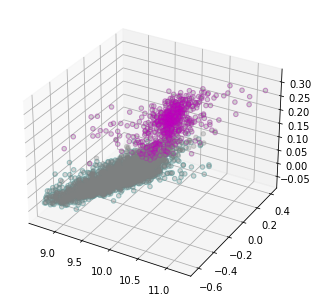

In [37]:
fig = plt.figure()
ax = Axes3D(fig)#fig.add_subplot(111, projection='3d')

def init():
    ax.scatter(cali_age, (rel_stars['C_FE']-rel_stars['N_FE']), rel_stars['ALPHA_M'],
              c='grey', label="useable stars", alpha=0.3)
    ax.scatter(cali_age[high_alpha], (rel_stars['C_FE']-rel_stars['N_FE'])[high_alpha], rel_stars['ALPHA_M'][high_alpha],
              c="none", edgecolors='m', label="high alpha", alpha=0.3)
    ax.scatter(cali_age[low_alpha], (rel_stars['C_FE']-rel_stars['N_FE'])[low_alpha], rel_stars['ALPHA_M'][low_alpha],
              c="none", edgecolors='c', label="low alpha", alpha=0.3)
#     ax.legend()
    return fig,

def animate(i):
    # azimuth angle : 0 deg to 360 deg
    ax.view_init(elev=10, azim=i*4)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=360, interval=20, blit=True)
fn = 'rotating_3D_CN_logAGE_Alpha'
# ani.save(fn+'.gif', fps=1000/50)
# cmd = 'magick convert %s.gif -fuzz 5%% -layers Optimize %s_r.gif'%(fn,fn)
# subprocess.check_output(cmd)
# plt.rcParams['animation.html'] = 'html5'
# ani

# Grab some example data and plot a basic wireframe.
# X, Y, Z = axes3d.get_test_data(0.05)
# ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
# # ax.scatter(cali_age, (rel_stars['C_FE']-rel_stars['N_FE']), rel_stars['ALPHA_M'])

# # Set the axis labels
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# # Rotate the axes and update
# for angle in range(0, 360*4 + 1):
#     # Normalize the angle to the range [-180, 180] for display
#     angle_norm = (angle + 180) % 360 - 180

#     # Cycle through a full rotation of elevation, then azimuth, roll, and all
#     elev = azim = roll = 0
#     if angle <= 360:
#         elev = angle_norm
#     elif angle <= 360*2:
#         azim = angle_norm
#     elif angle <= 360*3:
#         roll = angle_norm
#     else:
#         elev = azim = roll = angle_norm

#     # Update the axis view and title
# # ax.view_init(-140, 60)
#     ax.view_init(elev=elev, azim=azim, roll=roll)
#     plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))
#     plt.draw()
#     plt.pause(.001)
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)
# plt.show

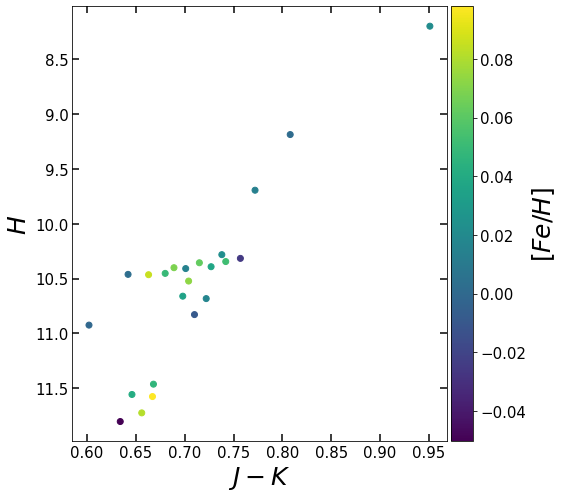

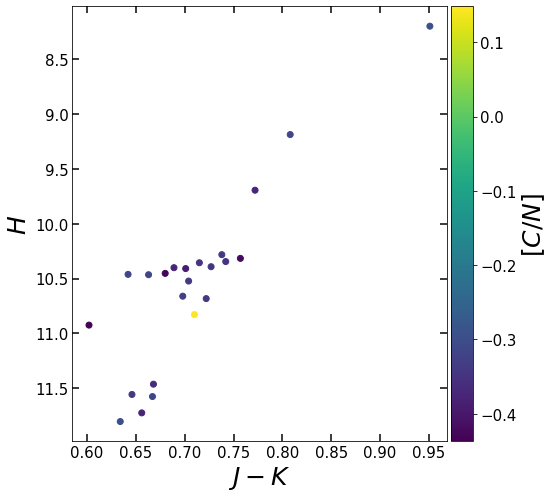

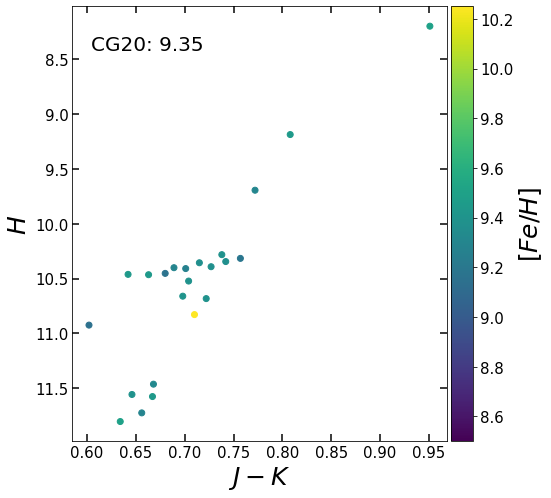

In [24]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# ax.scatter(cali_age_NGC6811, NGC6811[cn_cut_6811]['LOGG'], edgecolors='k',
#            zorder=5, alpha=1, label="NGC 6811", c="firebrick", s=90, marker="D")
# ax.scatter(cali_age_NGC6791, NGC6791[cn_cut_6791]['LOGG'], edgecolors='k',
#            zorder=5, alpha=1, c='limegreen', label="NGC 6791", s=90, marker="o")
# ax.scatter(cali_age_NGC6819, NGC6819[cn_cut_6819]['LOGG'], edgecolors='k',
#            zorder=5, alpha=1, c='dodgerblue', label="NGC 6819",s=90, marker="^")

image = ax.scatter(NGC6819['J'][cn_cut_6819]-NGC6819['K'][cn_cut_6819],
           NGC6819['H'][cn_cut_6819], c=NGC6819['FE_H'][cn_cut_6819])
bar = fig.colorbar(image,orientation="vertical",pad=0.01)
bar.ax.tick_params(labelsize=15)
bar.set_label('$[Fe/H]$',size=25)

# ax.legend()
# ax.invert_xaxis()
ax.invert_yaxis()
# ax.set_xlim(left=3.4, right=4)
# ax.set_ylim(top=4,bottom=0)
ax.set_ylabel('$H$', size=25)
ax.set_xlabel('$J-K$', size=25)
lineweight = 1.5   # thickness of tick marks
numsize = 15       # size of numbers on axs
ax.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# ax.scatter(cali_age_NGC6811, NGC6811[cn_cut_6811]['LOGG'], edgecolors='k',
#            zorder=5, alpha=1, label="NGC 6811", c="firebrick", s=90, marker="D")
# ax.scatter(cali_age_NGC6791, NGC6791[cn_cut_6791]['LOGG'], edgecolors='k',
#            zorder=5, alpha=1, c='limegreen', label="NGC 6791", s=90, marker="o")
# ax.scatter(cali_age_NGC6819, NGC6819[cn_cut_6819]['LOGG'], edgecolors='k',
#            zorder=5, alpha=1, c='dodgerblue', label="NGC 6819",s=90, marker="^")

image = ax.scatter(NGC6819['J'][cn_cut_6819]-NGC6819['K'][cn_cut_6819],
           NGC6819['H'][cn_cut_6819], c=(NGC6819['C_FE']-NGC6819['N_FE'])[cn_cut_6819])
bar = fig.colorbar(image,orientation="vertical",pad=0.01)
bar.ax.tick_params(labelsize=15)
bar.set_label('$[C/N]$',size=25)

# ax.legend()
# ax.invert_xaxis()
ax.invert_yaxis()
# ax.set_xlim(left=3.4, right=4)
# ax.set_ylim(top=4,bottom=0)
ax.set_ylabel('$H$', size=25)
ax.set_xlabel('$J-K$', size=25)
lineweight = 1.5   # thickness of tick marks
numsize = 15       # size of numbers on axs
ax.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# ax.scatter(cali_age_NGC6811, NGC6811[cn_cut_6811]['LOGG'], edgecolors='k',
#            zorder=5, alpha=1, label="NGC 6811", c="firebrick", s=90, marker="D")
# ax.scatter(cali_age_NGC6791, NGC6791[cn_cut_6791]['LOGG'], edgecolors='k',
#            zorder=5, alpha=1, c='limegreen', label="NGC 6791", s=90, marker="o")
# ax.scatter(cali_age_NGC6819, NGC6819[cn_cut_6819]['LOGG'], edgecolors='k',
#            zorder=5, alpha=1, c='dodgerblue', label="NGC 6819",s=90, marker="^")

image = ax.scatter(NGC6819['J'][cn_cut_6819]-NGC6819['K'][cn_cut_6819],
           NGC6819['H'][cn_cut_6819], c=cali_age_NGC6819, vmin=8.5, vmax=10.25)
bar = fig.colorbar(image,orientation="vertical",pad=0.01)
bar.ax.tick_params(labelsize=15)
bar.set_label('$[Fe/H]$',size=25)
ax.annotate("CG20: 9.35", xy=(0.05,.9), xytext=(0.05,0.9), xycoords='axes fraction', fontsize=20)

# ax.legend()
# ax.invert_xaxis()
ax.invert_yaxis()
# ax.set_xlim(left=3.4, right=4)
# ax.set_ylim(top=4,bottom=0)
ax.set_ylabel('$H$', size=25)
ax.set_xlabel('$J-K$', size=25)
lineweight = 1.5   # thickness of tick marks
numsize = 15       # size of numbers on axs
ax.tick_params(reset=True, direction='in', which='major', labelsize=numsize, width=lineweight, length=7, top=True, right=True)
ax.tick_params(direction='in', which='minor', labelsize=numsize, width=lineweight, length=4, top=True, right=True)


In [25]:
age_err = (np.abs(apok_logage-cali_age)/apok_logage)*100 #percent diff value
good_stars = age_err[np.where(age_err<=10)] # i want things that have a percent difference less than 10% (old 15%)
good_frac = (len(good_stars)/len(apok_logage))*100
print(good_frac)

99.67759269210103


11.229988 8.695488
10.251 8.584


/var/folders/pq/g29nzjzj609g39x310b8v67400013x/T/ipykernel_95665/3778638231.py:64: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "cobble" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"CN_GlobularClusters/One2One_CaliExtn_APOKASC.pdf", bbox_inches='tight', cobble = True)


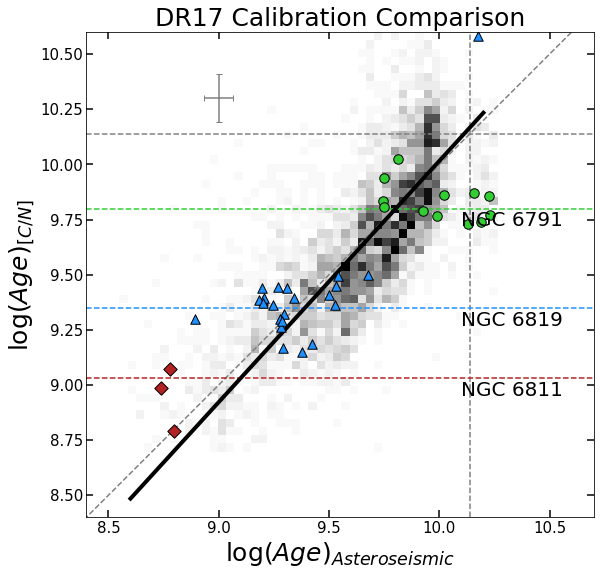

In [26]:
# print(np.max(fullcali_age), np.min(fullcali_age))
# print(np.max(fullapok_logage), np.min(fullapok_logage))
print(np.max(cali_age), np.min(cali_age))
print(np.max(apok_logage), np.min(apok_logage))

fig = plt.figure(figsize=(20,20))
fullage_vals = np.arange(8.6,10.25,0.1)
xvals = np.arange(7.3,11.3,0.1)
#Subfigure 1 - Carbon Abundance Comparison DR16 to DR17
ax = fig.add_subplot(121)
# ax.scatter(apok_logage, cali_age, zorder=3, alpha=0.4, s=10, c="cadetblue", label="Field Giants")
ax.scatter(apok_logage_NGC6811, cali_age_NGC6811,edgecolors='k',
           zorder=5, alpha=1, label="NGC 6811", c="firebrick", s=90, marker="D")
ax.scatter(apok_logage_NGC6791, cali_age_NGC6791,edgecolors='k',
           zorder=5, alpha=1, c='limegreen', label="NGC 6791", s=90, marker="o")
ax.scatter(apok_logage_NGC6819, cali_age_NGC6819,edgecolors='k',
           zorder=5, alpha=1, c='dodgerblue', label="NGC 6819",s=90, marker="^")

ax.errorbar(9.0, 10.3, yerr=np.median(cali_age_err), xerr=np.median(apokPerr_logage),
           c='tab:gray',fmt='.', markersize=.5, capsize=3, zorder=1)


bins = (np.linspace(8.4, 10.6, 60),
            np.linspace(8.4, 10.6, 60))

G, xe, ye = np.histogram2d(apok_logage,cali_age, bins=bins)
vmax = np.amax(G.T)
im = ax.pcolormesh(xe, ye, G.T, zorder=0,
                           cmap='Greys',
#                            norm=mpl.colors.LogNorm(vmin=0, vmax=vmax*1.5),
#                           vmin=0, vmax=vmax*1.5,
                           rasterized=True)

# ax.errorbar(apok_logage, cali_age, yerr=cali_age_err, xerr=[merr_logage,perr_logage],
#                 c='tab:gray',fmt='.', markersize=.5, capsize=3, zorder=0)
ax.plot(fullage_vals, linear(fullage_vals, *fit_vals), c="k", zorder=3, linestyle="-", linewidth=4)
ax.plot(xvals, xvals, c="grey", zorder=0, linestyle="--")

# ax.axhline(y=0, c="grey", zorder=1, linestyle="--")
ax.axvline(np.log10(13.8e9), c='grey', linestyle="--", zorder=0)
ax.axhline(np.log10(13.8e9), c='grey', linestyle="--", zorder=0)
ax.axhline(y=9.03, c="firebrick", zorder=0, linestyle="--", label="NGC 6811 CG-Age")
# ax.axhline(y=8.81, c="m", zorder=0, linestyle="--")
ax.axhline(y=9.8, c="limegreen", zorder=0, linestyle="--", label="NGC 6791 CG-Age")
ax.axhline(y=9.35, c="dodgerblue", zorder=0, linestyle="--", label="NGC 6819 CG-Age")
# ax.legend()
#ax.invert_xaxis()
#ax.invert_yaxis()
ax.set_xlim(left=8.4, right=10.7)
ax.set_ylim(top=10.6,bottom=8.4)
ax.set_aspect('equal', adjustable='box')
# ax.set_aspect(1)
ax.set_ylabel("$\log(Age)_{[C/N]}$",size=25)
ax.set_xlabel("$\log(Age)_{Asteroseismic}$",size=25)
ax.set_title("DR17 Calibration Comparison", size=25)
# props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# ax.text(0, 0.2, f"Slope: {poptC16[0]:.3f}", fontsize=16, bbox=props)
ax.text(10.1, 9.72, "NGC 6791", fontsize=20, zorder=10)
ax.text(10.1, 9.27, "NGC 6819", fontsize=20, zorder=10)
ax.text(10.1, 8.95, "NGC 6811", fontsize=20, zorder=10)
lineweight = 1.5
ax.tick_params(reset=True, direction='in', which='major', width=lineweight, length=7, top=True, right=True, labelsize=15)
ax.tick_params(direction='in', which='minor', width=lineweight, length=4, top=True, right=True, labelsize=15)
plt.savefig(f"CN_GlobularClusters/One2One_CaliExtn_APOKASC.pdf", bbox_inches='tight', cobble = True)

/var/folders/pq/g29nzjzj609g39x310b8v67400013x/T/ipykernel_95665/832379292.py:75: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "cobble" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"CN_GlobularClusters/DeltaAge_APOKASC_includesExtn.pdf", bbox_inches='tight', cobble = True)


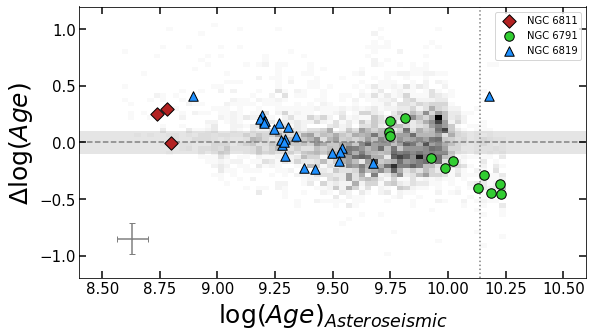

In [27]:
# print(np.max(fullcali_age), np.min(fullcali_age))
# print(np.max(fullapok_logage), np.min(fullapok_logage))
fig = plt.figure(figsize=(20,5))
fullage_vals = np.arange(8.6,10.25,0.1)
xvals = np.arange(7.3,11.3,0.1)
#Subfigure 1 - Carbon Abundance Comparison DR16 to DR17
ax = fig.add_subplot(121)
# ax.scatter(apok_logage, cali_age, zorder=3, alpha=0.4, s=10, c="cadetblue", label="Field Giants")
# ax.scatter(apok_logage_NGC6811, cali_age_NGC6811,edgecolors='k',
#            zorder=5, alpha=1, label="NGC 6811", c="firebrick", s=90, marker="D")
# # ax.scatter(apok_logage_NGC6866, cali_age_NGC6866,
# #            zorder=5, alpha=1, c='m', label="NGC 6866")
# ax.scatter(apok_logage_NGC6791, cali_age_NGC6791,edgecolors='k',
#            zorder=5, alpha=1, c='limegreen', label="NGC 6791", s=90, marker="o")
# ax.scatter(apok_logage_NGC6819, cali_age_NGC6819,edgecolors='k',
#            zorder=5, alpha=1, c='dodgerblue', label="NGC 6819",s=90, marker="^")

ax.scatter(apok_logage_NGC6811, (cali_age_NGC6811-apok_logage_NGC6811),edgecolors='k',
           zorder=5, alpha=1, label="NGC 6811", c="firebrick", s=90, marker="D")
ax.scatter(apok_logage_NGC6791, (cali_age_NGC6791-apok_logage_NGC6791),edgecolors='k',
           zorder=5, alpha=1, c='limegreen', label="NGC 6791", s=90, marker="o")
ax.scatter(apok_logage_NGC6819, (cali_age_NGC6819-apok_logage_NGC6819),edgecolors='k',
           zorder=5, alpha=1, c='dodgerblue', label="NGC 6819",s=90, marker="^")

ax.errorbar(8.63, -0.85, yerr=np.median(delta_age), xerr=np.median(apokPerr_logage),
           c='tab:gray',fmt='.', markersize=.5, capsize=3, zorder=1)

# ax.scatter(apok_logage, -1*(apok_logage-cali_age), alpha=0.3)


# bins = (np.linspace(8.4, 10.6, 60),
#             np.linspace(8.4, 10.6, 60))
bins = (np.linspace(-2.0, 2.0, 60),
            np.linspace(8.4, 10.6, 60))
#Delta_age = CNage - APOKASCage
G, xe, ye = np.histogram2d(apok_logage,cali_age-apok_logage, bins=(60,60))
vmax = np.amax(G.T)
im = ax.pcolormesh(xe, ye, G.T, zorder=0,
                           cmap='Greys',
#                            norm=mpl.colors.LogNorm(vmin=0, vmax=vmax*1.5),
#                           vmin=0, vmax=vmax*1.5,
                           rasterized=True)

# ax.errorbar(apok_logage, cali_age, yerr=cali_age_err, xerr=[merr_logage,perr_logage],
#                 c='tab:gray',fmt='.', markersize=.5, capsize=3, zorder=0)
# ax.plot(fullage_vals, linear(fullage_vals, *poptFULL), c="k", zorder=3, linestyle="-", linewidth=4)
# ax.plot(xvals, xvals, c="grey", zorder=0, linestyle="--")

ax.axhline(y=0, c="grey", zorder=0, linestyle="--")
ax.fill_between(xvals, 0.1, -0.1, alpha=0.3, facecolor="darkgrey", zorder=0)
ax.axvline(np.log10(13.8e9), c='grey', linestyle=":", zorder=0)
# ax.axvline(np.log10(13.8e9+200e6), c='grey', linestyle="--", zorder=0)
# ax.axhline(y=9.03, c="firebrick", zorder=0, linestyle="--", label="NGC 6811 CG-Age")
# # ax.axhline(y=8.81, c="m", zorder=0, linestyle="--")
# ax.axhline(y=9.8, c="limegreen", zorder=0, linestyle="--", label="NGC 6791 CG-Age")
# ax.axhline(y=9.35, c="dodgerblue", zorder=0, linestyle="--", label="NGC 6819 CG-Age")
ax.legend()
#ax.invert_xaxis()
#ax.invert_yaxis()
ax.set_xlim(left=8.4, right=10.6)
ax.set_ylim(top=1.2,bottom=-1.2)
# ax.set_aspect('equal', adjustable='box')
# ax.set_aspect(1)
ax.set_ylabel("$\Delta \log(Age)$",size=25)
ax.set_xlabel("$\log(Age)_{Asteroseismic}$",size=25)
# ax.set_title("DR17 Calibration Comparison", size=25)
# props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# ax.text(0, 0.2, f"Slope: {poptC16[0]:.3f}", fontsize=16, bbox=props)
# ax.text(10.12, 9.72, "NGC 6791", fontsize=20)
# ax.text(10.12, 9.27, "NGC 6819", fontsize=20)
# ax.text(10.12, 8.95, "NGC 6811", fontsize=20)
lineweight = 1.5
ax.tick_params(reset=True, direction='in', which='major', width=lineweight, length=7, top=True, right=True, labelsize=15)
ax.tick_params(direction='in', which='minor', width=lineweight, length=4, top=True, right=True, labelsize=15)
plt.savefig(f"CN_GlobularClusters/DeltaAge_APOKASC_includesExtn.pdf", bbox_inches='tight', cobble = True)

/var/folders/pq/g29nzjzj609g39x310b8v67400013x/T/ipykernel_95665/1834929708.py:74: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "cobble" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"CN_GlobularClusters/DeltaAge_CNAge_includesExtn.pdf", bbox_inches='tight', cobble = True)


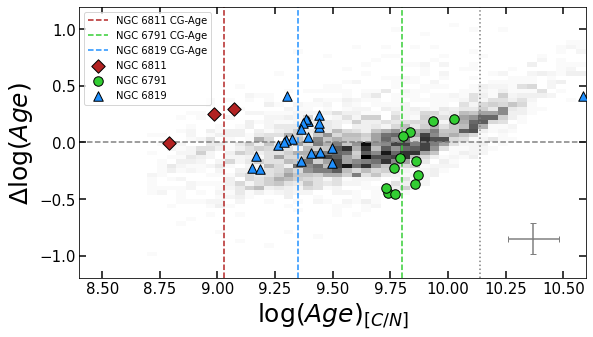

In [28]:
# print(np.max(fullcali_age), np.min(fullcali_age))
# print(np.max(fullapok_logage), np.min(fullapok_logage))
fig = plt.figure(figsize=(20,5))
fullage_vals = np.arange(8.6,10.25,0.1)
xvals = np.arange(7.3,11.3,0.1)
#Subfigure 1 - Carbon Abundance Comparison DR16 to DR17
ax = fig.add_subplot(121)
# ax.scatter(apok_logage, cali_age, zorder=3, alpha=0.4, s=10, c="cadetblue", label="Field Giants")
# ax.scatter(apok_logage_NGC6811, cali_age_NGC6811,edgecolors='k',
#            zorder=5, alpha=1, label="NGC 6811", c="firebrick", s=90, marker="D")
# # ax.scatter(apok_logage_NGC6866, cali_age_NGC6866,
# #            zorder=5, alpha=1, c='m', label="NGC 6866")
# ax.scatter(apok_logage_NGC6791, cali_age_NGC6791,edgecolors='k',
#            zorder=5, alpha=1, c='limegreen', label="NGC 6791", s=90, marker="o")
# ax.scatter(apok_logage_NGC6819, cali_age_NGC6819,edgecolors='k',
#            zorder=5, alpha=1, c='dodgerblue', label="NGC 6819",s=90, marker="^")

ax.scatter(cali_age_NGC6811, cali_age_NGC6811-apok_logage_NGC6811,edgecolors='k',
           zorder=5, alpha=1, label="NGC 6811", c="firebrick", s=90, marker="D")
ax.scatter(cali_age_NGC6791, cali_age_NGC6791-apok_logage_NGC6791,edgecolors='k',
           zorder=5, alpha=1, c='limegreen', label="NGC 6791", s=90, marker="o")
ax.scatter(cali_age_NGC6819, cali_age_NGC6819-apok_logage_NGC6819,edgecolors='k',
           zorder=5, alpha=1, c='dodgerblue', label="NGC 6819",s=90, marker="^")

ax.errorbar(10.37, -0.85, yerr=np.median(delta_age), xerr=np.median(cali_age_err),
           c='tab:gray',fmt='.', markersize=.5, capsize=3, zorder=1)

# ax.scatter(apok_logage, -1*(apok_logage-cali_age), alpha=0.3)


# bins = (np.linspace(8.4, 10.6, 60),
#             np.linspace(8.4, 10.6, 60))
bins = (np.linspace(-2.0, 2.0, 60),
            np.linspace(8.4, 10.6, 60))
#Delta_age = CNage - APOKASCage
G, xe, ye = np.histogram2d(cali_age, cali_age-apok_logage, bins=(60,60))
vmax = np.amax(G.T)
im = ax.pcolormesh(xe, ye, G.T, zorder=0,
                           cmap='Greys',
#                            norm=mpl.colors.LogNorm(vmin=0, vmax=vmax*1.5),
#                           vmin=0, vmax=vmax*1.5,
                           rasterized=True)

# ax.errorbar(apok_logage, cali_age, yerr=cali_age_err, xerr=[merr_logage,perr_logage],
#                 c='tab:gray',fmt='.', markersize=.5, capsize=3, zorder=0)
# ax.plot(fullage_vals, linear(fullage_vals, *poptFULL), c="k", zorder=3, linestyle="-", linewidth=4)
# ax.plot(xvals, xvals, c="grey", zorder=0, linestyle="--")

ax.axhline(y=0, c="grey", zorder=0, linestyle="--")
ax.axvline(np.log10(13.8e9), c='grey', linestyle=":", zorder=0)
# ax.axvline(np.log10(13.8e9+200e6), c='grey', linestyle="--", zorder=0)
ax.axvline(9.03, c="firebrick", zorder=0, linestyle="--", label="NGC 6811 CG-Age")
# # ax.axhline(y=8.81, c="m", zorder=0, linestyle="--")
ax.axvline(9.8, c="limegreen", zorder=0, linestyle="--", label="NGC 6791 CG-Age")
ax.axvline(9.35, c="dodgerblue", zorder=0, linestyle="--", label="NGC 6819 CG-Age")
ax.legend()
#ax.invert_xaxis()
#ax.invert_yaxis()
ax.set_xlim(left=8.4, right=10.6)
ax.set_ylim(top=1.2,bottom=-1.2)
# ax.set_aspect('equal', adjustable='box')
# ax.set_aspect(1)
ax.set_ylabel("$\Delta \log(Age)$",size=25)
ax.set_xlabel("$\log(Age)_{[C/N]}$",size=25)
# ax.set_title("DR17 Calibration Comparison", size=25)
# props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# ax.text(0, 0.2, f"Slope: {poptC16[0]:.3f}", fontsize=16, bbox=props)
# ax.text(10.12, 9.72, "NGC 6791", fontsize=20)
# ax.text(10.12, 9.27, "NGC 6819", fontsize=20)
# ax.text(10.12, 8.95, "NGC 6811", fontsize=20)
lineweight = 1.5
ax.tick_params(reset=True, direction='in', which='major', width=lineweight, length=7, top=True, right=True, labelsize=15)
ax.tick_params(direction='in', which='minor', width=lineweight, length=4, top=True, right=True, labelsize=15)
plt.savefig(f"CN_GlobularClusters/DeltaAge_CNAge_includesExtn.pdf", bbox_inches='tight', cobble = True)

Steps to create the comparison to the two methods
- grab stars that are within both APOGEE and APOKASC (need xmatch)
- apply stellar evolution cuts for FDU and respective extra mixinf cuts for metal poor stars.
- also grab OCs that are in both samples to see how new calibration changes those values. (are there GCs in the APOKASC sample?)


TS THOUGHTS: I want to do a one to one plot of just metal poor not extra mixing stars and compare this regime by itself. IDK if this is would be helpful but might be interesting. **thinking emoji